Action items
* Check tsne loss
* Do you need a more specific SentenceTransformer?

In [87]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE

In [2]:
ds = load_dataset("ryanwtsai/MTS_Dialogue-Clinical_Note_TrainValTestSplit")
ds

DatasetDict({
    train: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 1040
    })
    val: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 132
    })
    test: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 128
    })
})

In [16]:
df = {key: pd.DataFrame(value) for key, value in ds.items()}

In [23]:
# model = SentenceTransformer("all-mpnet-base-v2") # max seq len = 384
model = SentenceTransformer("all-distilroberta-v1")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

C:\ProgramData\anaconda3\envs\env_dl_cv_transformer_sentpiece\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Encodings

In [25]:
threshold = model.max_seq_length
for key in df:
    df[key] = df[key].loc[df[key]['length'] <= threshold, :]
    df[key]['output_length'] = df[key]['labels'].apply(lambda x: len(x))

In [102]:
for key in df:
    print(key + ":")
    print(df[key]['length'].describe())
    print(df[key]['output_length'].describe())
    print("-------------------------------------------------")

train:
count    998.000000
mean     136.387776
std      113.609340
min       15.000000
25%       54.000000
50%       94.000000
75%      180.750000
max      509.000000
Name: length, dtype: float64
count    998.000000
mean      62.084168
std       29.648880
min       18.000000
25%       41.000000
50%       53.000000
75%       74.000000
max      237.000000
Name: output_length, dtype: float64
-------------------------------------------------
val:
count    127.000000
mean     126.960630
std       96.867394
min       19.000000
25%       57.000000
50%       96.000000
75%      167.000000
max      425.000000
Name: length, dtype: float64
count    127.000000
mean      59.661417
std       25.864488
min       32.000000
25%       41.000000
50%       51.000000
75%       74.500000
max      148.000000
Name: output_length, dtype: float64
-------------------------------------------------
test:
count    121.000000
mean     137.752066
std      119.399908
min       15.000000
25%       52.000000
50%       91

In [103]:
embeddings = {key: model.encode(list(df[key]['dialogue'])) for key in df}
embeddings_out = {key: model.encode(list(df[key]['section_text'])) for key in df}

In [104]:
num_samples = {key: embeddings[key].shape[0] for key in embeddings}
for key in embeddings:
    print(f"{key}: {embeddings[key].shape}, {embeddings_out[key].shape}")
print(num_samples)

train: (998, 768), (998, 768)
val: (127, 768), (127, 768)
test: (121, 768), (121, 768)
{'train': 998, 'val': 127, 'test': 121}


In [105]:
embeddings_all = np.concatenate((embeddings['train'], embeddings['val'], embeddings['test']))
embeddings_out_all = np.concatenate((embeddings_out['train'], embeddings_out['val'], embeddings_out['test']))
print(embeddings_all.shape)
print(embeddings_out_all.shape)

(1246, 768)
(1246, 768)


In [113]:
tsne = TSNE()
embeddings_tsne = tsne.fit_transform(embeddings_all)
kl_div = tsne.kl_divergence_
embeddings_out_tsne = tsne.fit_transform(embeddings_out_all)
kl_div_out = tsne.kl_divergence_
print(embeddings_tsne.shape)
print(embeddings_out_tsne.shape)
print(kl_div)
print(kl_div_out)

(1246, 2)
(1246, 2)
1.3308080434799194
1.3310203552246094


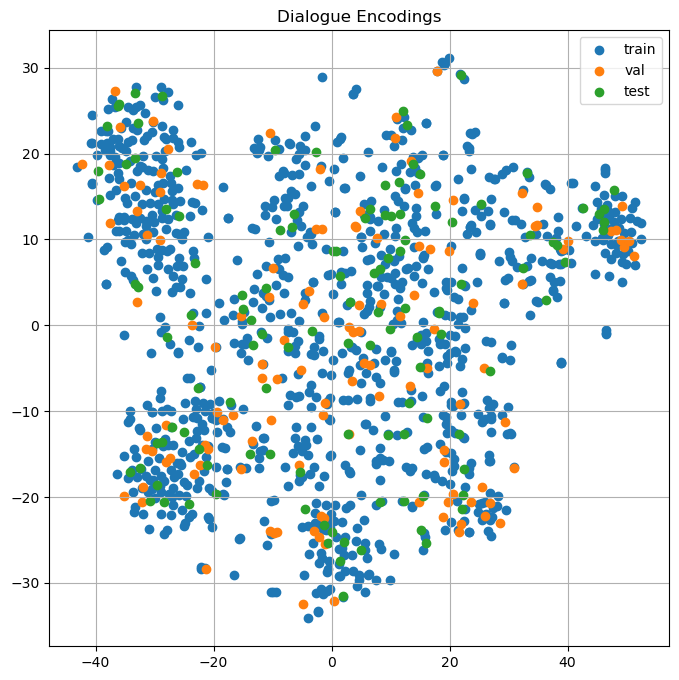

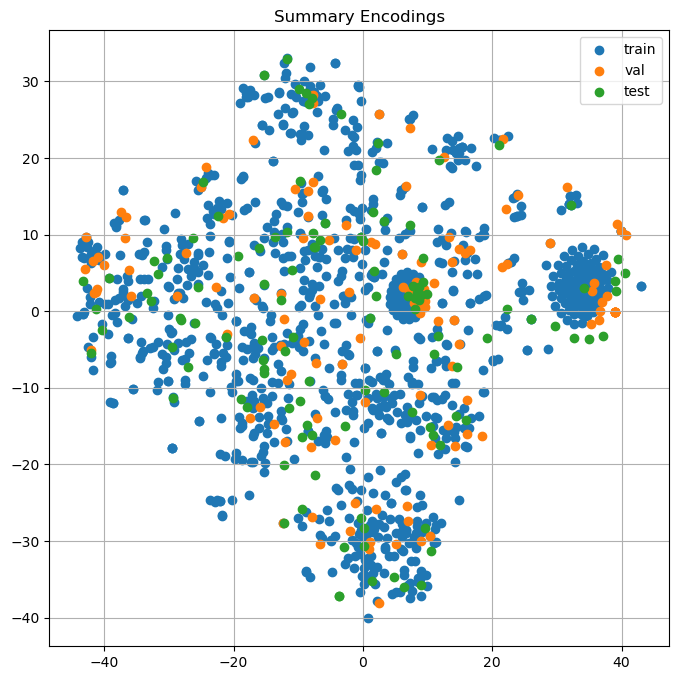

In [108]:
plt.figure(figsize=(8,8))
plt.scatter(embeddings_tsne[:num_samples['train'], 0], embeddings_tsne[:num_samples['train'], 1], label="train")
plt.scatter(embeddings_tsne[num_samples['train']:num_samples['train']+num_samples['val'], 0], embeddings_tsne[num_samples['train']:num_samples['train']+num_samples['val'], 1], label="val")
plt.scatter(embeddings_tsne[num_samples['train']+num_samples['val']:, 0], embeddings_tsne[num_samples['train']+num_samples['val']:, 1], label="test")
plt.title("Dialogue Encodings")
plt.legend()
plt.grid()

plt.figure(figsize=(8,8))
plt.scatter(embeddings_out_tsne[:num_samples['train'], 0], embeddings_out_tsne[:num_samples['train'], 1], label="train")
plt.scatter(embeddings_out_tsne[num_samples['train']:num_samples['train']+num_samples['val'], 0], embeddings_out_tsne[num_samples['train']:num_samples['train']+num_samples['val'], 1], label="val")
plt.scatter(embeddings_out_tsne[num_samples['train']+num_samples['val']:, 0], embeddings_out_tsne[num_samples['train']+num_samples['val']:, 1], label="test")
plt.title("Summary Encodings")
plt.legend()
plt.grid()